In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, root
import csv
import pandas as pd
from IPython.display import Image
import progressbar

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def inch2m(inch):
    return inch * 0.0254

def m2inch(m):
    return m/0.0254

def loadcsvfile(filename, path='data/', delimiter=';'):
    exceldata = pd.read_excel(path+filename)
    exceldata.to_csv(path+'csv/'+filename[:-5]+'.csv', sep=delimiter, index=None, header=True)
    csvdata = pd.read_csv(path+'csv/'+filename[:-5]+'.csv', delimiter=delimiter)
    csvdata = csvdata.iloc[1:]
    csvdata.index -= 1
    for key in csvdata:
        if key != 'experiment':
            csvdata[key] = csvdata[key].astype('float')
    return csvdata

In [3]:
HaEl1 = loadcsvfile('Harleman_Elder_1.xlsx')
HaEl2 = loadcsvfile('Harleman_Elder_2.xlsx')
NL1204 = loadcsvfile('Noordland_M1204.xlsx')
IJ = loadcsvfile('IJmuiden.xlsx')

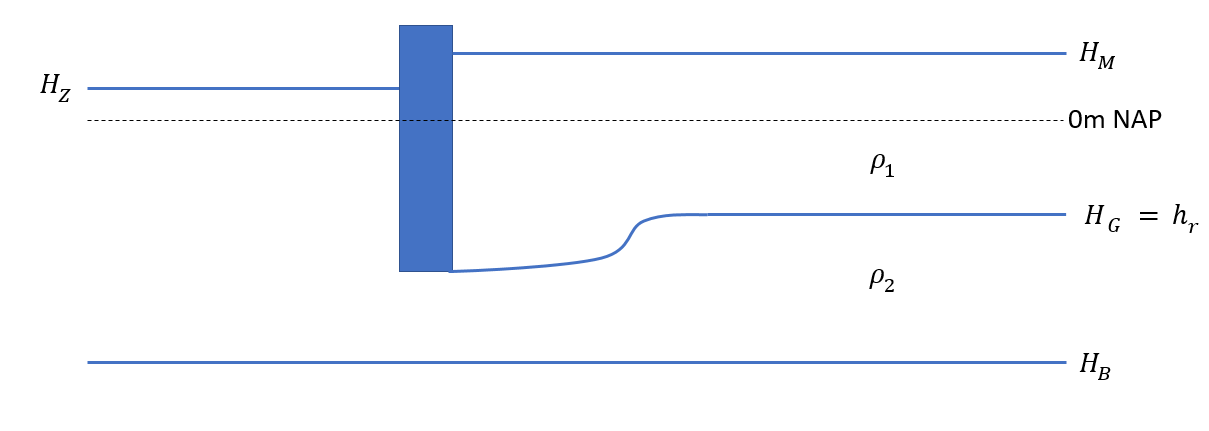

In [4]:
Image("images/schematic_withdrawal_bottom.PNG", width=750)

In [5]:
g = 9.81 # [m s^-2] gravitatieversnelling
rho_1 = 1000 # [kg m^-3] dichtheid zoet water
rho_2 = 1022 # [kg m^-3] dichtheid zout water
Drho = rho_2 - rho_1 # [kg m^-3] dichtheidsverschil
eps = Drho/rho_2
gp = g*Drho / rho_2
H_B = -17 # [mNAP] niveau bodem
H_Z = 2 # [mNAP] waterniveau zeezijde
H_M = 3 # [mNAP] waterniveau meerzijde

# Islam figure 3 (similar to Jirka figure 3)

In [6]:
def myFunction(f):
    F2s = f[0]
    h1 = f[1]
    h2 = f[2]
    q1 = f[3]
    q2 = f[4]
    
    F = np.zeros(5)
    F[0] = F1s - (1-Drho/rho_2*F1s)*(1-F2s)
    F[1] = Drho/rho_2*F1s - (H1/h1 + H2/h1 - h2/h1 - 1)
    F[2] = F2s/2 - F1s/2*h1/h2 + 1 - H2/h2
    F[3] = F1s - pow(q1,2)/(gp*pow(h1,3))
    F[4] = F2s - pow(q2,2)/(gp*pow(h2,3))
    
    return F

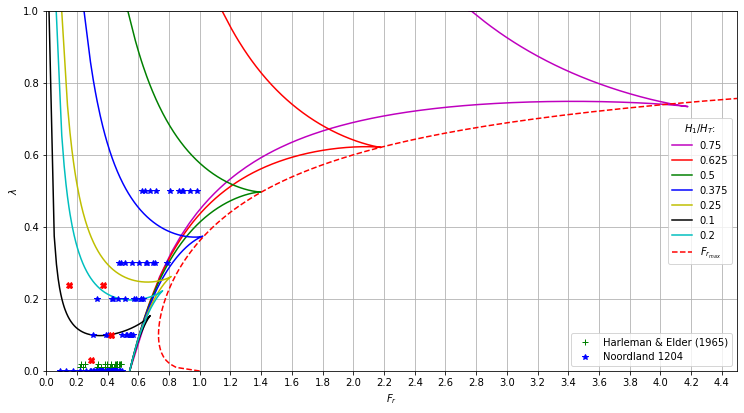

In [7]:
H_T = H_M - H_B

H2_arr = np.array([5, 7.5, 10, 12.5, 15, 18, 16])
plotcolor = np.array(['m', 'r', 'g', 'b', 'y', 'k', 'c'])

figprops = dict(figsize=(12, 10), dpi=72)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .8, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='')
xmax = 4.5
ymax = 1
ax.axis([0,xmax,0,ymax])
ax.set_xticks(np.arange(0,xmax,0.2))
ax.grid()

fGuess = np.array([1,1,1,1,1])
for i in range(H2_arr.size):
    H2 = H2_arr[i]
    H1 = H_T - H2
    F1s_arr = np.linspace(0,1,1000)
    Fr = np.zeros((F1s_arr.size))
    lam = np.zeros((F1s_arr.size))
    for ii in range(F1s_arr.size):
        F1s = F1s_arr[ii]
        fsol = root(myFunction, fGuess, method='lm')
        [F2s, h1, h2, q1, q2] = fsol.x
        #fGuess = np.array([F2s, h1, h2, q1, q2])
        Fr[ii] = (q1+q2)/np.sqrt(gp*pow(H2,3))
        lam[ii] = q1/(q1+q2)

    #ax.plot(Fr[:np.where(Fr==max(Fr))[0][0]], lam[:np.where(Fr==max(Fr))[0][0]], plotcolor[i], label='{}'.format(H1/H_T))
    ax.plot(Fr, lam, plotcolor[i], label='{}'.format(H1/H_T))

lammax = np.linspace(0,0.99,100)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)
ax.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')
    
lgnd1 = ax.legend(title='$H_1/H_T$:', loc='center right')
[lgnd1.legendHandles[jj]._legmarker.set_markersize(10) for jj in range(6)]

HaElplot, = ax.plot(pd.concat([HaEl1.Fr, HaEl2.Fr]), pd.concat([HaEl1.lam, HaEl2.lam]), '+g')
sel = np.where(NL1204.D<2/3*NL1204.hr)[0]
NL1204plot, = ax.plot(NL1204.iloc[sel].Fr, NL1204.iloc[sel].lam, '*b')
IJplot = ax.plot(IJ.Fr, IJ.lam, 'Xr')
lgnd2 = ax.legend([HaElplot, NL1204plot], ['Harleman & Elder (1965)', 'Noordland 1204'], loc='lower right')
ax.add_artist(lgnd1)

#plt.savefig('figures/discharge_ratios.png', bbox_inches='tight')
plt.show()


The upper half portion of each curve presents a scenario when the line sink is located at
the upper layer.

# Fix hr/H
Bij gebruik van fsolve kwamen errors dat die niet convergeert. Bij gebruik van root(..., method='lm') zijn deze errors er niet meer.

H1/HT = 0.75
lam at Frmax is [0.73442598]


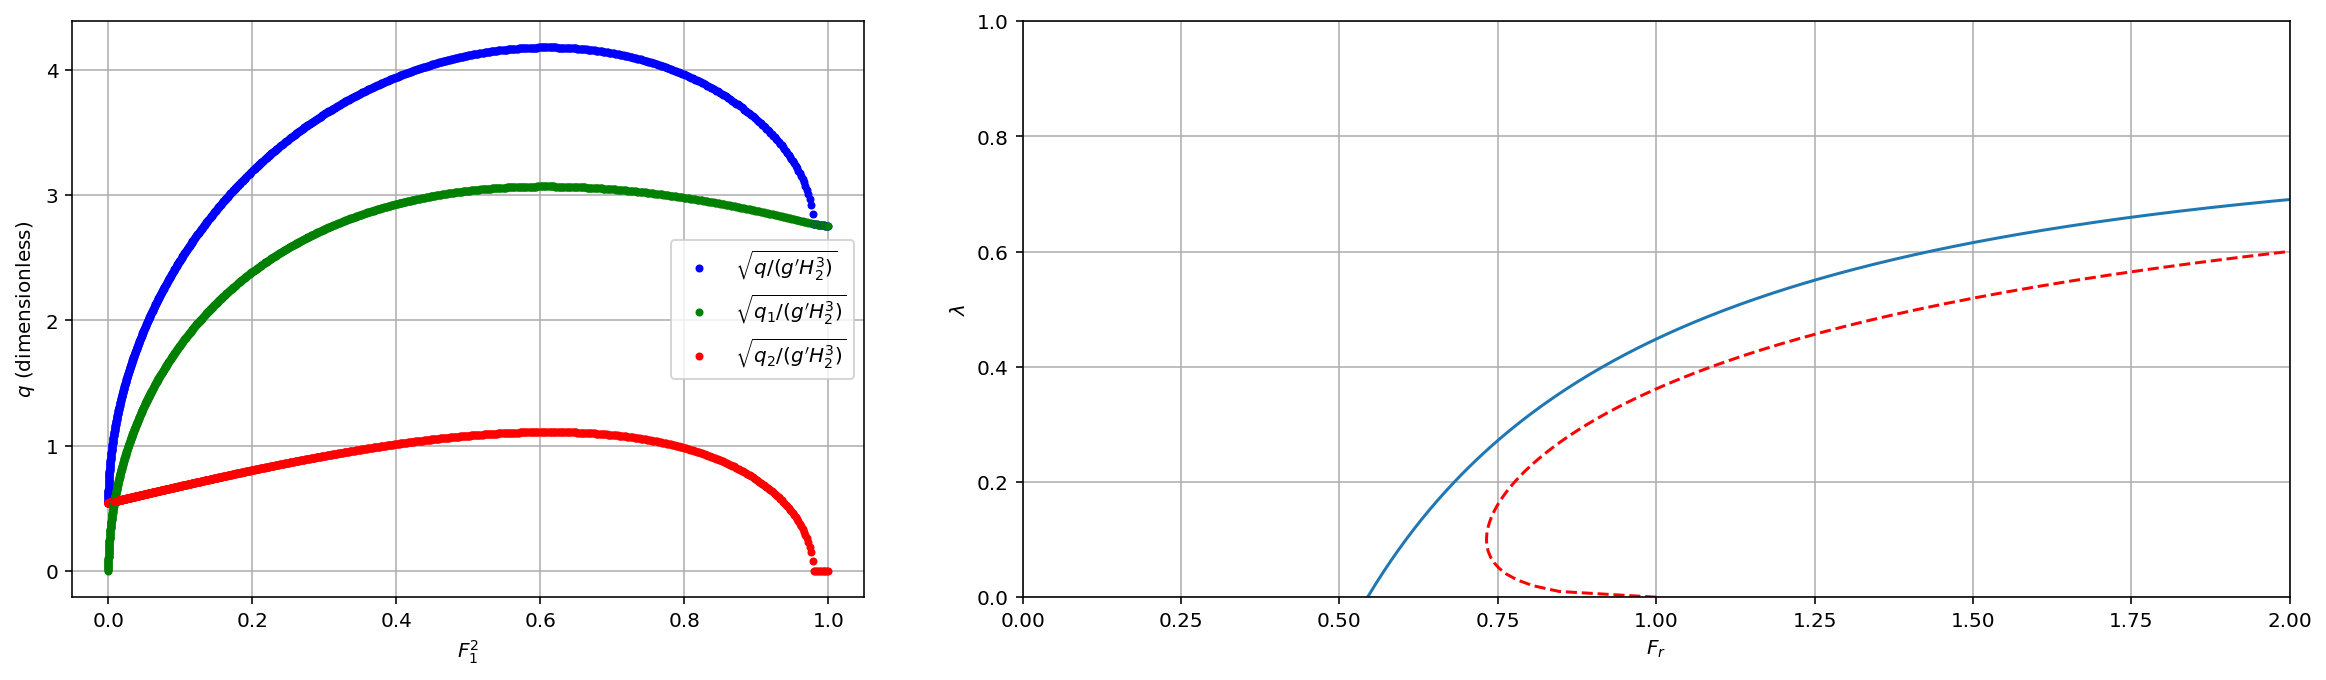

In [19]:
figprops = dict(figsize=(11, 8), dpi=144)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_1^2$', ylabel='$q$ (dimensionless)', title='')
ax.grid()

bx = plt.axes([.6, 0, .8, .5])
bx.set(xlabel='$F_r$', ylabel='$\lambda$', title='')
bx.axis([0,2,0,1])
bx.grid()

F1s_arr = np.linspace(0,1,1001)**2
Fr = np.zeros((F1s_arr.size))
lam = np.zeros((F1s_arr.size))
f = np.zeros((F1s_arr.size, 5))

H_T = H_M - H_B

H2 = .25*H_T
H1 = H_T - H2
print("H1/HT = {}".format(H1/H_T))

lammax = np.linspace(0,0.99,100)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)

fGuess = np.array([1,1,1,1,1])
for ii in range(F1s_arr.size):
    F1s = F1s_arr[ii]
    F2s, h1, h2, q1, q2 = root(myFunction, fGuess, method='lm').x
    #fGuess = [F2s, h1, h2, q1, q2]
    
    if ii==0: #ugly if statement to quickly fix legend
        ax.plot(F1s, (q1+q2)/(gp*H2**3)**.5, '.b', label="$\sqrt{q/(g'H_2^3)}$")
        ax.plot(F1s, q1/(gp*H2**3)**.5, '.g', label="$\sqrt{q_1/(g'H_2^3)}$")
        ax.plot(F1s, q2/(gp*H2**3)**.5, '.r', label="$\sqrt{q_2/(g'H_2^3)}$")
    else:
        ax.plot(F1s, (q1+q2)/(gp*H2**3)**.5, '.b')
        ax.plot(F1s, q1/(gp*H2**3)**.5, '.g')
        ax.plot(F1s, q2/(gp*H2**3)**.5, '.r')
    f[ii] = [F2s, h1, h2, q1, q2]
    Fr[ii] = (q1+q2)/np.sqrt(gp*pow(H2,3))
    lam[ii] = q1/(q1+q2)

print('lam at Frmax is {}'.format(lam[Fr==max(Fr)]))
    
bx.plot(Fr, lam, label='{}'.format(H2/H_T))
bx.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')
ax.legend()

#plt.savefig('figures/islam_fig_2_and_3.png', bbox_inches='tight')
plt.show()

In [15]:
lam[Fr==max(Fr)]

array([0.49734399])

# Jirka figure 3 and 4

In [84]:
def myEffectivenessFunction(f):
    q1 = f[0]
    q2 = f[1]
    hc = f[2]
    
    F = np.zeros(3)
    #F[0] = q1**2/(gp*(H-hc)**3) + q2**2/(gp*hc**3) - 1
    F[0] = q1**2/(gp*(H-hc)**3) - (1-eps*q1**2/(gp*(H-hc)**3))*(1-q2**2/(gp*hc**3))
    F[1] = hr - hc - q2**2/(2*gp*hc**2) + q1**2/(2*gp*(H-hc)**2)
    F[2] = q1 - lam*(q1+q2)
    
    return F

In [86]:
np.array([5, 7.5, 10, 12.5, 15, 18])/20

array([0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.9  ])

<ipython-input-84-0b79e0476af4>:8: RuntimeWarning: divide by zero encountered in true_divide
  F[0] = q1**2/(gp*(H-hc)**3) - (1-eps*q1**2/(gp*(H-hc)**3))*(1-q2**2/(gp*hc**3))
<ipython-input-84-0b79e0476af4>:8: RuntimeWarning: divide by zero encountered in double_scalars
  F[0] = q1**2/(gp*(H-hc)**3) - (1-eps*q1**2/(gp*(H-hc)**3))*(1-q2**2/(gp*hc**3))
<ipython-input-84-0b79e0476af4>:8: RuntimeWarning: invalid value encountered in double_scalars
  F[0] = q1**2/(gp*(H-hc)**3) - (1-eps*q1**2/(gp*(H-hc)**3))*(1-q2**2/(gp*hc**3))
<ipython-input-84-0b79e0476af4>:9: RuntimeWarning: divide by zero encountered in true_divide
  F[1] = hr - hc - q2**2/(2*gp*hc**2) + q1**2/(2*gp*(H-hc)**2)
<ipython-input-84-0b79e0476af4>:9: RuntimeWarning: divide by zero encountered in double_scalars
  F[1] = hr - hc - q2**2/(2*gp*hc**2) + q1**2/(2*gp*(H-hc)**2)
<ipython-input-84-0b79e0476af4>:8: RuntimeWarning: divide by zero encountered in true_divide
  F[0] = q1**2/(gp*(H-hc)**3) - (1-eps*q1**2/(gp*(H-hc)**3))*(

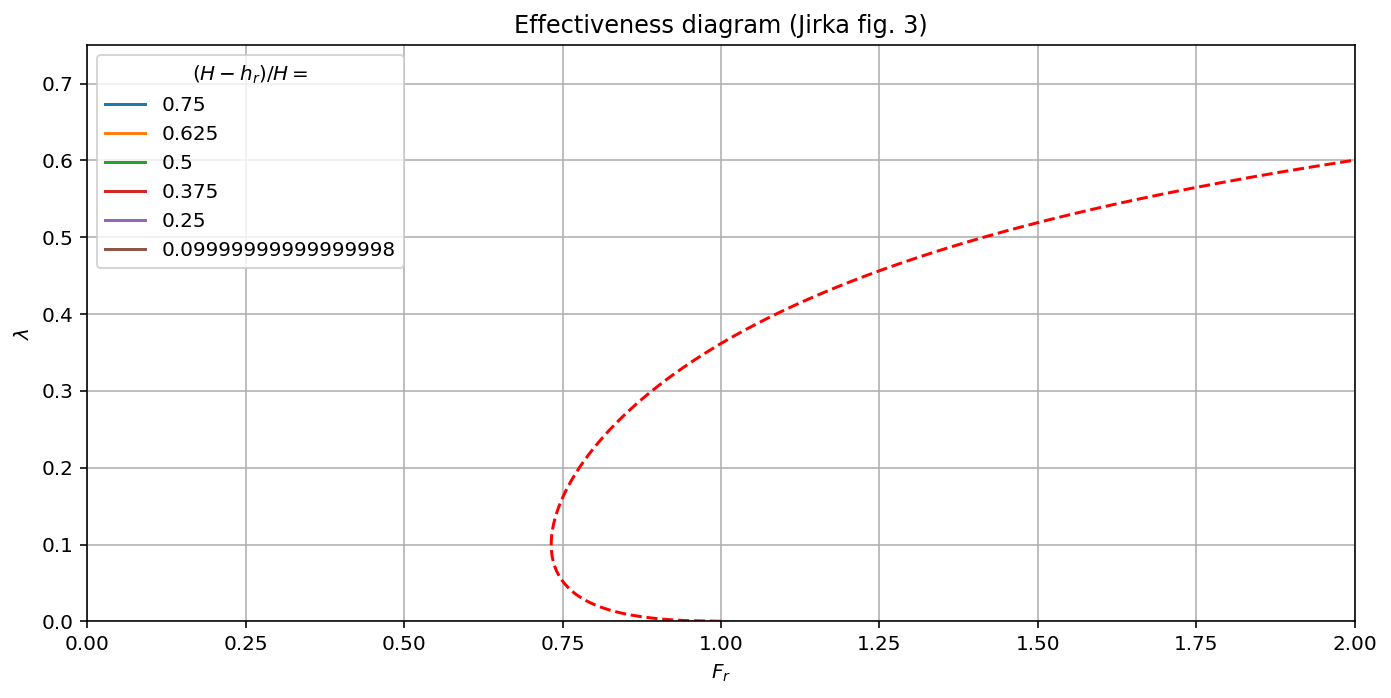

In [87]:
figprops = dict(figsize=(11, 8), dpi=144)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .8, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='Effectiveness diagram (Jirka fig. 3)')
ax.axis([0,2,0,0.75])
ax.grid()

H = 1
#hr_arr = np.array([5, 7.5, 10, 12.5, 15, 18])
hr_arr = np.array([0.25, 0.375, 0.5, 0.625, 0.75, 0.9])

for hr in hr_arr:
    lam_arr = np.linspace(0,0.99,1000)
    Fr = np.zeros((lam_arr.size))
    Frmax = pow(1-lam_arr, -5/2)*pow(1+np.sqrt(lam_arr/(1-lam_arr)),-2)
    hc_arr = np.zeros((lam_arr.size))
    f = np.zeros((lam_arr.size, 3))

    for ii in range(lam_arr.size):
        lam = lam_arr[ii]

        fGuess = np.array([1,1,1])
        q1, q2, hc = root(myEffectivenessFunction, fGuess, method='lm').x
        fGuess = [q1, q2, hc]
        f[ii] = [q1, q2, hc]
        Fr[ii] = (q1+q2)/np.sqrt(gp*pow(hr,3))
        #if lam >= 1-hr/H:
        #    break

    ax.plot(Fr[:ii+1], lam_arr[:ii+1], label='{}'.format((H-hr)/H))
ax.plot(Frmax, lam_arr, '--r')
ax.legend(title='$(H-h_r)/H = $')
#plt.savefig('figures/jirka_fig4.png', bbox_inches='tight')
plt.show()

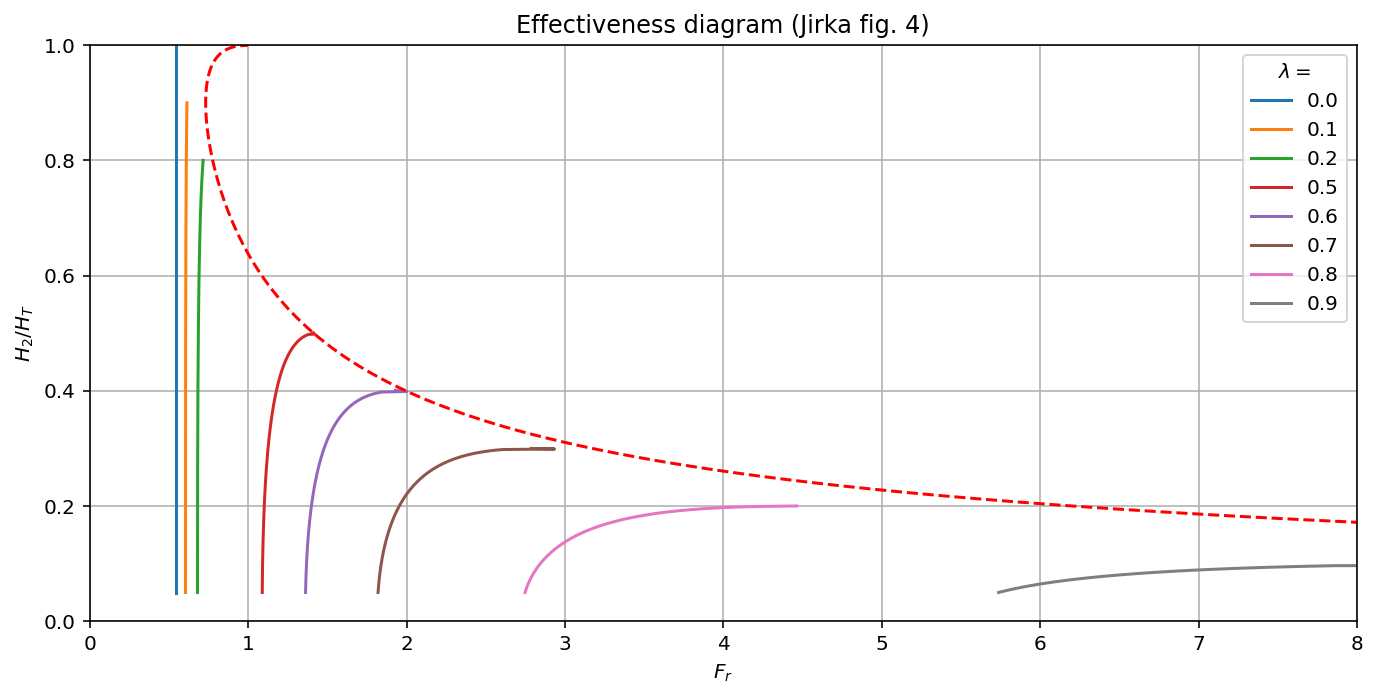

In [10]:
figprops = dict(figsize=(11, 8), dpi=144)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .8, .5])
ax.set(xlabel='$F_r$', ylabel='$H_2/H_T$', title='Effectiveness diagram (Jirka fig. 4)')
ax.axis([0,8,0,1])
ax.grid()

H = 20
lam_arr = np.array([0, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9])

for lam in lam_arr:
    hr_arr = np.linspace(1,H_T,1000)
    Fr = np.zeros((hr_arr.size))
    Frmax = pow(H/hr_arr,5/2)*pow(1+np.sqrt(H/hr_arr-1),-2)
    hc_arr = np.zeros((hr_arr.size))
    f = np.zeros((hr_arr.size, 3))

    for ii in range(hr_arr.size):
        hr = hr_arr[ii]

        fGuess = np.array([1,1,1])
        q1, q2, hc = root(myEffectivenessFunction, fGuess, method='lm').x
        fGuess = [q1, q2, hc]
        f[ii] = [q1, q2, hc]
        Fr[ii] = (q1+q2)/np.sqrt(gp*pow(hr,3))
        if hr/H >= 1-lam:
            break

    ax.plot(Fr[:ii+1], hr_arr[:ii+1]/H, label='{}'.format(lam))
ax.plot(Frmax, hr_arr/H, '--r')
ax.legend(title='$\lambda = $')
#plt.savefig('figures/jirka_fig4.png', bbox_inches='tight')
plt.show()

# Plots Yu et al.

In [11]:
c = pd.DataFrame({'lam': np.array([0.24, 0.03, 0.1, 0.24]),
                  'q': np.array([9.9, 29.6, 29.6, 29.6])*1e3/199.5e-2,
                  'y': np.array([15.6, 7.7, 20.6, 23.7])*1e-3,
                  'Fr': np.array([0.15, 0.29, 0.42, 0.37])})

In [12]:
c

,lam,q,y,Fr
0,0.24,4962.406015,0.0156,0.15
1,0.03,14837.092732,0.0077,0.29
2,0.10,14837.092732,0.0206,0.42
3,0.24,14837.092732,0.0237,0.37


In [13]:
q2 = NL1204.q-NL1204.q1

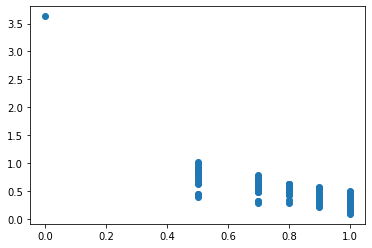

In [14]:
plt.plot(q2/NL1204.q, NL1204.Fr, 'o')

[Text(0.5, 0, "$g'h_c^3/q_o^2$"),
 Text(0, 0.5, '$C_o/C_L = q_L/q_o = 1-\\lambda$')]

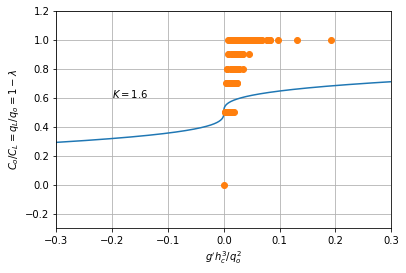

In [15]:
K = 1.6
A = np.linspace(-1,1,100000)
c0cL = np.zeros(len(A))
c0cL[A<=0] = 0.5*(1-abs(A[A<=0])**(1/3)/K)
c0cL[A>0]  = 0.5*(1+abs(A[A>0])**(1/3)/K)
plt.plot(A, c0cL)
plt.plot(NL1204.rhofrac*9.81*NL1204.hr**3/NL1204.q, 1-NL1204.lam, 'o')
plt.text(-0.2,0.6,'$K={}$'.format(K))

plt.axis([-0.3,0.3,-.3,1.2])
plt.grid()
plt.gca().set(xlabel="$g'h_c^3/q_o^2$", ylabel="$C_o/C_L = q_L/q_o = 1-\lambda$")